In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# split into words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from collections import Counter

import os
from pathlib import Path



import src.utils.utils as ut
import src.utils.model_utils as mu
import src.utils.sparse_matrix as sm
import src.data.dataframe as dat
import src.features.build_features as bf

/home/lisa/Schreibtisch/e-commerce


Using TensorFlow backend.


# First step:  load the description file (.csv) and have a look at it

**Remarks:**
It appears that the delimiter is not a default one, e.g. a space, but rather a semicolon.  We account for that while loading.

In [2]:
df = dat.read_df(os.path.join(ut.dirs.raw_dir,
                              ut.df_names.original_df))
df.head()

,sku,title,category,image_url
0,97060179,Schwarze Spinellkette mit 750- Bajonettverschluß,Schmuck > Ketten > Colliers,https://img02.nyris.io/demo/challenge/97060179...
1,106801871,Raute Diamant Messing Stecker Ohrstecker,Schmuck > Ohrschmuck > Ohrstecker,https://img02.nyris.io/demo/challenge/10680187...
2,89643247,Schildkrötenset mit Ohrringen und Kette kristall,Schmuck > Ketten > Gliederketten,https://img02.nyris.io/demo/challenge/89643247...
3,107668051,"Handgefertigtes Seidenband habotai, #254.6",Schmuck > Armbänder & Armreife > Wickelarmbänder,https://img02.nyris.io/demo/challenge/10766805...
4,10143554,Kettenanhänger Rosenblüte,Schmuck > Anhänger > Schmuckanhänger,https://img02.nyris.io/demo/challenge/10143554...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
sku          100000 non-null int64
title        99890 non-null object
category     100000 non-null object
image_url    100000 non-null object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


In [4]:
print('Number of unique skus')
print(df.sku.nunique())
print(df['sku'].describe())
print('')
print('Number of different titles')
print(df.title.nunique())
print(df['title'].describe())
print('')
print('Number of different categories')
print(df.category.nunique())
print(df['category'].describe())
print('')
print('Number of different urls')
print(df.image_url.nunique())

Number of unique skus
100000
count    1.000000e+05
mean     9.631393e+07
std      2.730933e+07
min      2.690500e+04
25%      8.176116e+07
50%      1.059826e+08
75%      1.179711e+08
max      1.238230e+08
Name: sku, dtype: float64

Number of different titles
87776
count        99890
unique       87776
top       Ohrringe
freq           135
Name: title, dtype: object

Number of different categories
365
count                            100000
unique                              365
top       Kunst > Drucke > Digitaldruck
freq                               6512
Name: category, dtype: object

Number of different urls
100000


In [5]:
df.isna().sum()

sku            0
title        110
category       0
image_url      0
dtype: int64

In [6]:
print(df.title.isna().sum()/len(df)*100, '% of our samples miss a title')

0.11 % of our samples miss a title


## First results about the data

We find that the data consists of 100.000 samples each described by 
* a unique sku (int64) and 
* a unique url (string) 

(those values to be unique is plausible).  Furthermore, each sample has 

* a title (string)
* a category (string) which is an ensemble of subcategories

**Remarks:**
* We find 365 unique (sub)category ensembles
* 110 samples miss a title
* The title might be used later to enrich the information fed into the classifier.  Probably we will get rid of the 110 samples which miss this value.  Thereby, we lose less ~0.11 % of our data which is an acceptable trade-off for a first attempt.

# Next step:  expand the string-encoded category ensembles
by adding rows to the dataframe.  

This step is needed to gain some statistical insights into the distribution of samples among the different (sub)categories.

In [7]:
expanded_categories = df['category'].str.split(' > ')

expanded_categories holds now a list of subcategories originally encoded in the category string.

To enrich the dataframe by this information, we have to consider the number of subcategories originally encoded in the category string.  To this end, cound them:

In [8]:
expanded_categories.apply(lambda x: len(x)).value_counts()

3    100000
Name: category, dtype: int64

We find that each original category string consists of 3 (sub)categories.  With this insight we are safe to add this information to our dataframe by means of the following:

In [9]:
expanded_categories = expanded_categories.\
            apply(pd.Series).\
            rename({0: 'product_category', 
                    1: 'product_type', 
                    2: 'product_details'}, axis='columns')

In [10]:
df = df.join(expanded_categories)

Now our dataframe is ready to gain insight into the distribution of (sub)categories.  

# Step 3: investigate the distribution of (sub)categories

First, we want to see how many items belong to each of the product_category 

In [11]:
df['category_count'] = df.groupby(['category'])['category'].transform('count')
df['product_category_count'] = df.groupby(['product_category'])['product_category'].transform('count')
df['product_type_count'] = df.groupby(['product_type'])['product_type'].transform('count')
df['product_details_count'] = df.groupby(['product_details'])['product_details'].transform('count')

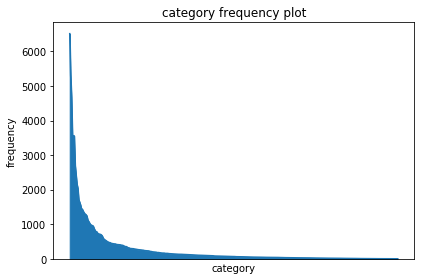

In [12]:
plt.figure()
ax = df['category'].value_counts().plot(kind='area')

ax.get_xaxis().set_ticks([])
ax.set_title('category frequency plot')
ax.set_xlabel('category')
ax.set_ylabel('frequency')

plt.tight_layout()
plt.show()

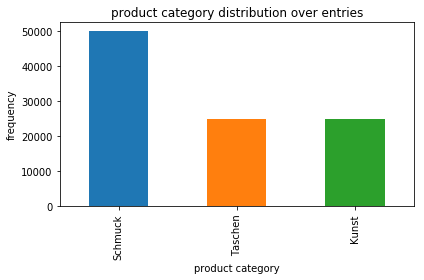

In [13]:
plt.figure()
ax = df['product_category'].value_counts().plot(kind='bar')

ax.set_title('product category distribution over entries')
ax.set_xlabel('product category')
ax.set_ylabel('frequency')

plt.tight_layout()
plt.show()

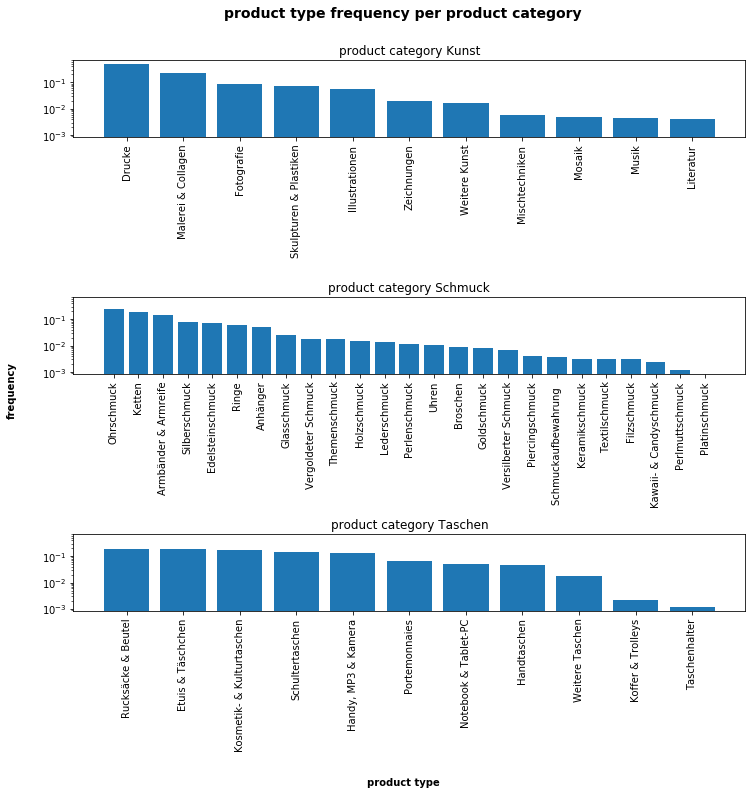

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(11,11))

# Normalize value counts for better comparison
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

for idx, g in enumerate(df.groupby('product_category')):
    label, val = normalize_group(g[1]["product_type"].value_counts())
    num = len(label)
    ax = axes.flat[idx]
    ax.bar(np.arange(num), val[:num],
           tick_label=label[:num])     
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.set_yscale("log", nonposy='clip')
    ax.set_title("product category {}".format(g[0]))
    
fig.text(0.5, 0.97, 'product type frequency per product category', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'product type', ha='center', fontweight='bold')
fig.text(0, 0.5, 'frequency', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])

In [15]:
def extract_data(data = df, cat1 = None, cat2 = None):
    temp = data['product_category'].value_counts()
    checksum = np.sum(temp)
    if cat1 != None:
        temp = data[data['product_category'] == cat1]['product_type'].value_counts()
        checksum = np.sum(temp)
        if cat2 != None:
            temp = data[(data['product_category'] == cat1) & 
                        (data['product_type'] == cat2)]['product_details'].value_counts()            
    
    labels = np.asarray(temp.keys().tolist())
    counts = np.asarray(temp.tolist())
    
    median = np.percentile(counts, 50)
    mean = np.mean(counts)
    
    return labels, counts, mean, median

In [16]:
df['catcount'] = df.groupby(['category'])['category'].transform('count')

# Next step:  investigate a bit more on the title feature

We want to investigate the title feature in a bit more detail to get an idea if this information might be useful for further considerations.

As a first approach one might investigate the length of the title with respect to its frequency of occurence.  

The function prepare_data equalizes the length of each product category subset in order to plot the information encoded there.

In [17]:
df['length_title'] = df['title'].fillna('').apply(lambda x: x.split(' ')).apply(lambda x: len(x))

In [18]:
def prepare_data(column = 'title', product_category = None):
    if(column=='title'):
        title_lengths = df[column].fillna('').apply(lambda x: x.split(' ')).apply(lambda x: len(x))
    else:
        title_lengths = df[column].fillna('').apply(lambda x: len(x))
        
    default_size = len(title_lengths.value_counts()) + 1

    if product_category != None:
        if(column=='title'):
            title_lengths = df[df['product_category'] == product_category][column].fillna('').apply(lambda x: x.split(' ')).apply(lambda x: len(x))
        else:           
            title_lengths = df[df['product_category'] == product_category][column].fillna('').apply(lambda x: len(x))
    
    mean = np.mean(title_lengths)
    median = np.percentile(title_lengths, 50)
    
    counter = title_lengths.value_counts()
    
    string_lengths = np.asarray(counter.keys().tolist())
    ix = np.argsort(string_lengths)
    string_lengths = string_lengths[ix]
    string_length_counts = np.asarray(counter.tolist())[ix]
    
    if len(ix) != default_size:
        temp = np.zeros((default_size), dtype=int)
        temp[string_lengths] = string_length_counts
        string_length_counts = temp
        string_lengths = np.arange(default_size)
        
    assert (len(string_lengths) == default_size)
    
    return string_lengths, string_length_counts, mean, median

Define the plotting function.  This function creates a histogram showing the *title lengths vs. counts* for each product category (Schmuck, Taschen, Kunst) as well as a comprehensive histogram.

In [19]:
def title_statistics(data = df, column = 'title'):    
    f, ax = plt.subplots(nrows=4, ncols=1, sharey=True, figsize=(11,11))

    colors = ['#990000', '#009999', '#404040']   
    
    categories = list(set(data.product_category.values))
    
    lengths = []
    counts = []
    p = []
   
    for i, cat in enumerate(categories):
        l, c, mean, median = prepare_data(column, cat)        
        lengths.append(l)
        counts.append(c)
        
        ax[i].bar(l, c, color = colors[i], label=cat)
        
        #ax[i].set_title(cat + ' title statistics', fontsize=15)
        ax[i].set_ylabel('counts', fontsize = 15)
        ax[i].legend(loc="upper left", fontsize=15)
        ax[i].tick_params(labelsize = 15)
        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        
        ax[i].axvline(median, color='black', linewidth=2)
        ax[i].axvline(mean, color='black', linewidth=2)

        # Add arrows annotating the means:
        for name, x0, xoff in zip(['Median', 'Mean'], [median, mean], [15, -15]):
            align = 'left' if xoff > 0 else 'right'
            ax[i].annotate(name+': {:0.2f}'.format(x0), xy=(x0, 1), xytext=(xoff, 10),
                    xycoords=('data', 'axes fraction'), textcoords='offset points',
                    horizontalalignment=align, verticalalignment='center',
                    arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                                    connectionstyle='angle,angleA=0,angleB=90,rad=10'),
                    )

        
    for i in reversed(range(len(counts))):        
        p.append(plt.bar(lengths[i], counts[i], 
                         bottom = np.sum([counts[j] for j in range(i)], axis=0), 
                         color = colors[i],
                         label = categories[i]))

    
    ax[3].set_title('overall title statistics', fontsize=15)
    ax[3].set_xlabel('title lengths', fontsize = 15)
    ax[3].set_ylabel('counts', fontsize = 15)
    ax[3].legend(loc="upper left", fontsize=15)
    ax[3].tick_params(labelsize = 15)
    
    fig.text(0.5, 0.97, 'product type frequency per product category', ha='center', fontsize=14, fontweight='bold')
    fig.text(0.5, 0, 'product type', ha='center', fontweight='bold')
    fig.text(0, 0.5, 'frequency', va='center', rotation='vertical', fontweight='bold')
    #fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])
    plt.show()

Plot the title lengths vs. counts for each product category:

/home/lisa/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


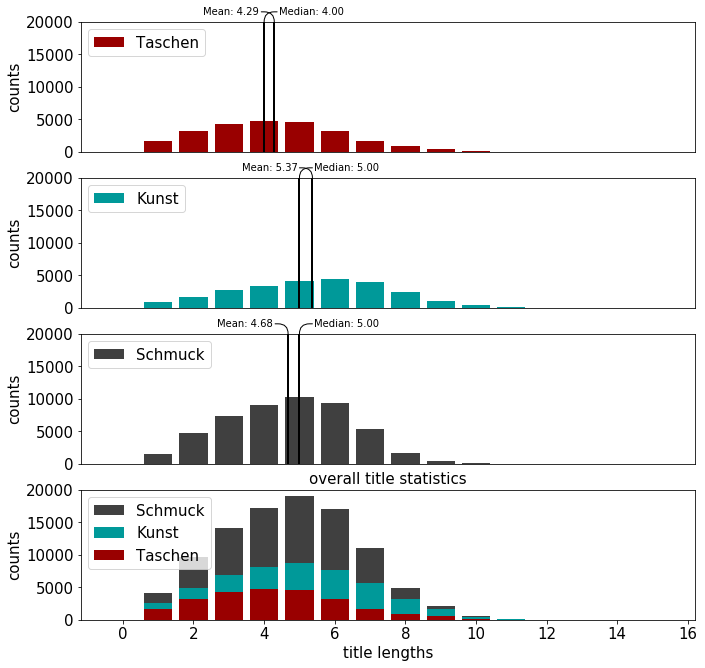

In [20]:
title_statistics(df, 'title')

## Intermediate results:  

From the histograms it becomes evient that maximum length of titles describing the products is 50 characters.  

The distributions are slightly skewed.


# Next step:  clean the titles
As a next step, we'd like to clean the titles from 

* stop words
* words, that are not important for the content (deadlist)
* words, that are shorter than 3 characters
* words, that are composed from one and the same character (e.g. iii)

Furthermore we'd like to 

* reduce the words to their stemms
* transfer them into lower case representation
* transfer German umlauts into vowels
* reduce the words to their stemms


In [21]:
def cleaning(text):
    deadlist = ['mit', 'xxl', 'xxxl', 'uvp', 'xcm', 'grs', 'grm', 'grl', 'tlg','xxcm', 'xcm']
    transfer = {
        ord('ä'): 'ae',
        ord('ö'): 'oe',
        ord('ü'): 'ue',
        ord('ß'): 'ss'
    }
    # tokenize the text string
    tokens = word_tokenize(text)
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    
    # transfer German umlauts into vowels
    tokens = [w.translate(transfer) for w in tokens]
    
    # remove punctuation and digits from each word
    table = str.maketrans('', '', string.punctuation + string.digits)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]    

    # reduce words to their stemms
    porter = PorterStemmer()
    stemmed = list(set([porter.stem(word) for word in words]))
    
    # filter out 
    #   stop words, 
    #   words that are contained in the deadlist, 
    #   words that are shorter than 3 characters and 
    #   words which are assembled only from one and the same identical character
    stop_words = set(stopwords.words(['english', 'german']) + deadlist)
    words = [w for w in stemmed if not w in stop_words and len(w) > 2 and len(Counter(w)) > 1]
    
    # et voilà 
    return words

In [22]:
df['reduced_title'] = df['title'].fillna('').apply(lambda x: cleaning(x))
df['concat_reduced_title'] = df['reduced_title'].apply(lambda x: ' '.join(x))
df['length_reduced_title'] = df['reduced_title'].apply(lambda x: len(x))

/home/lisa/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


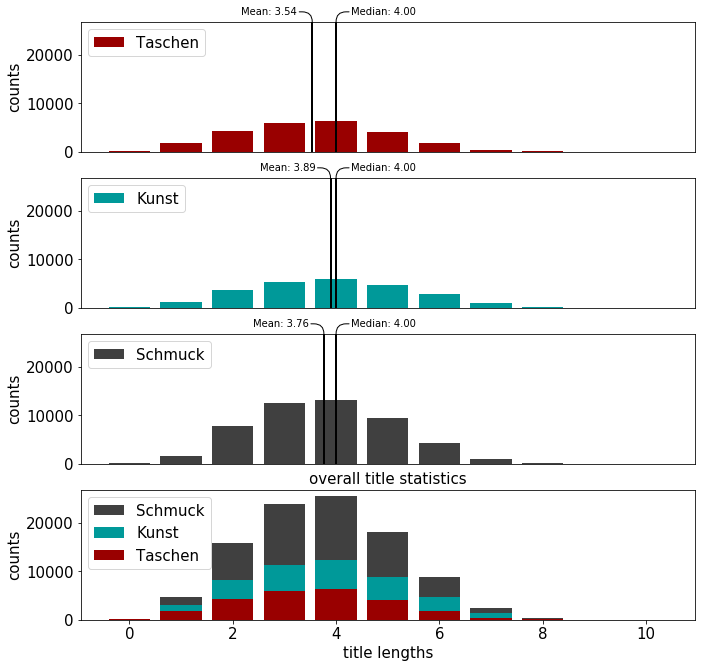

In [23]:
title_statistics(df, 'reduced_title')

## Intermediate results

These histograms look a lot more balanced.  In fact, they are almost Gaussian shaped, the maximum length is 8, the minimum length is 0 words, median and mean are close together.  

In [24]:
list_of_words = df['reduced_title'].apply(pd.Series).stack().value_counts()

In [25]:
len(list(set(list_of_words.keys())))

33985